# Objective
- We want to train a model to predict a car's price based on it's mileage.
- we'll use linear regression with one variable.
- Linear regression aims to find a linear relation of the form y = ax + b;
    - With y being the output, x being the input.
    - a and b are the weight and bias respectively. Our goal is to find optimal values for them.
- The output (price) is called a label, and the inputs (the mileage) are called features.
- We will have a linear equation of the form price = weight * mileage + bias.

# Library Imports

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math 
from pandas import DataFrame

# Loading & Exploring Data
- We'll load the data from a csv file.
- Use a pandas dataframe to store it.
- We will also display graphs for the mileage and price.

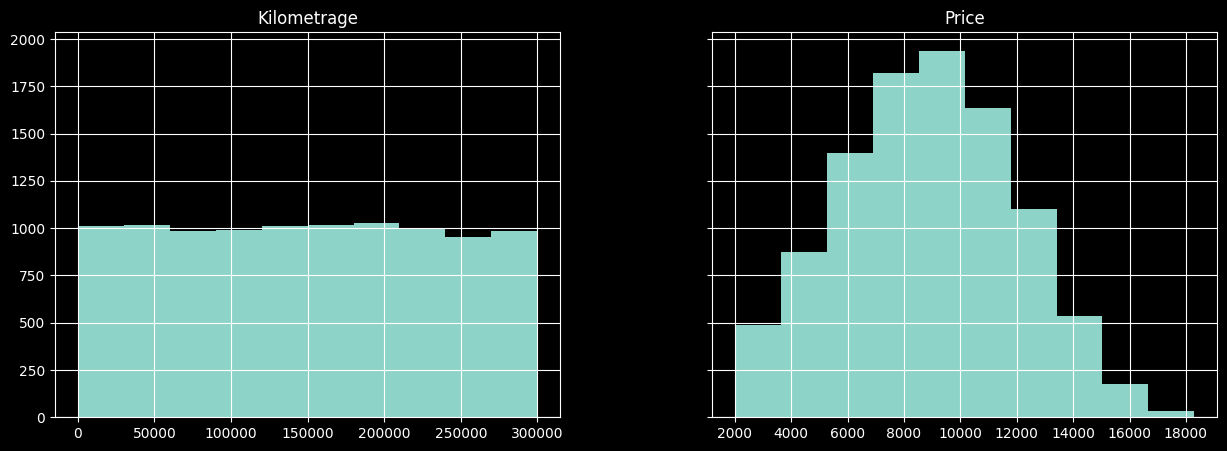

In [32]:
df = pd.read_csv('car_price_dataset.csv')

## Only Keep the columns that are needed
# Kilometrage, Price
originalDf = df[['Kilometrage', 'Price']]
df = df[['Kilometrage', 'Price']]

df.hist(figsize=(15,5),sharey=True)

# Transform miles to km
df['Kilometrage'] = df['Kilometrage'] * 1.60934

# Normalization
- Normalization is used to transform the range of a feature into a smaller one. (in this case, the mileage is the feature).
- This helps make better predictions, increase training speed, and avoid overflows.
- Since the frequency of the mileage follows (roughly) a uniform distribution, then we should use linear scaling.
- Linear scaling transform the values into a standard $[0,1]$ range
$$x = \frac{x'-x_{min}}{x_{max}-x_{min}}$$
- Where :
	- $x$ is the initial value.
	- $x'$ is the normalized value
	- $x_{max},x_{min}$ are the minimum and maximum values of the dataset.

- We should also normalize the label (price) inorder to avoid overflows.

In [33]:
max_kilometrage = df["Kilometrage"].max()
min_kilometrage = df["Kilometrage"].min()
df["Kilometrage"] = (df["Kilometrage"] - min_kilometrage) / (max_kilometrage - min_kilometrage)

max_price = df["Price"].max()
min_price = df["Price"].min()
df["Price"] = (df["Price"] - min_price) / (max_price - min_price)


# Loss Function
- The loss is the distance between the predicted value, and the actual value from the dataset.
- Here we calculate the Mean Square Error, which is the average of the squared difference of each example in a set of examples.
- $$MSE = \frac{1}{M}\sum_{i=1}^{M}(w *x_{i} + b - y_i)^2$$
- Where :
    - $M$ is the size of the set of examples.
    - $y_i$ is the output (price) of the $i^{th}$ example.
    - $x_i$ is the input (kilometrage) of the $i^{th}$ example.
    - $w$ is the weight.
    - $b$ is the bias.
- However, since data is normalized, we need to denormalize it first.
- Note that the below function is not used for training our model. It is only used to calculate the final loss of our model.

In [ ]:
def loss_func(batch : DataFrame, b, w1): 
    # Calculate denormalized loss
    sum = 0
    for i in range(batch.shape[0]):
        denormalized_price = batch.at[i, "Price"] * (max_price - min_price) + min_price
        denormalized_kilometrage = batch.at[i, "Kilometrage"] * (max_kilometrage - min_kilometrage) + min_kilometrage
        denormalized_b = b * (max_price - min_price) + min_price
        denormalized_w1 = w1 * (max_price - min_price) / (max_kilometrage - min_kilometrage)
        sum = sum + (denormalized_price - (denormalized_b + denormalized_w1 * denormalized_kilometrage)) ** 2

    return sum / (batch.shape[0])

# Gradient Descent
- As we've seen above, linear regression aims to produce optimal weights and bias.
- However, what does optimal weights and bias actually mean ?
- Optimal weights and bias are the ones that, when used to predict examples, produce the minimal loss.
- Gradient Descent is a technique that iteratively finds the weights and bias that produce the lowest loss.
## Process
- Start with weights and bias at 0.
- For each weight, and the bias : determine the direction to move them that reduces loss.
- Move a small amount in that direction.
- Repeat until loss can't be reducer further (the modal converges)
## Hyperparameters
- Hyperparameters are variables that control different aspects of learning :
    1. **Learning Rate:** It determines the magnitude of changes made to the weights and bias at each iteration. Lower values cause convergence to slow down, higher values cause the model to not converge.
    2. **Batch Size:** The number of examples of the dataset to be treated in each iteration.
    3. **Epochs:** It determines how many times each example in the dataset has to be processed. Higher values improve the model accuracy, but increase training time.

In [35]:
def gradient_descent(dataset: DataFrame, batch_size : int, learning_rate: float,epochs : int):
    loss_history = []
    b = 0 # bias 
    w1 = 0 # weight
    iteration_count = math.ceil(dataset.shape[0]* epochs / batch_size)
    
    for iter in range(iteration_count):
        batch = dataset.sample(batch_size,ignore_index=True)
        loss = loss_func(batch, b, w1)
        loss_history.append(loss)

        # Calculate slope of the loss function with respect to w0 and w1
        # The bias first :


        b = move_bias(b,w1,learning_rate,batch)
        w1 = move_weight(b,w1,learning_rate,batch)
    return [b, w1, loss_history, iter]



## Moving the coefficients
- We need to move the weight and the bias in the direction that reduces loss.
- First, we need to find that direction for each of the weight of the bias.
- We need to calculate the slope of the loss function in relation to the weight, and to the bias.
- For the weight :
    - Let $M$ be the batch size. then the MSE is 
    $$MSE = \frac{1}{M}\sum_{i=1}^{M}(w *x_{i} + b - y_i)^2$$
    - In order to move the weight in the direction that reduces loss, then we need the partial derivative of the loss in regards to the weight
    $$\text{weight slope} = \frac{\delta}{\delta w} MSE = \frac{1}{M}\sum_{i=1}^{M}(w *x_{i} + b - y_i) * 2 x_{i}$$
    - So the new weight will move by a small amount in the inverse direction of the above value
    $$w = w - \epsilon * \text{weight slope}$$
- Using a similar method, we can calculate the bias slope 
$$\text{bias slope} =  2 * \frac{1}{M}\sum_{i=1}^{M}(w *x_{i} + b - y_i)$$

In [ ]:
def move_bias(b,w1, learning_rate, batch):
    slope = 0;
    for i in range(batch.shape[0]):
        slope += (batch.at[i,"Price"] - (b + w1 * batch.at[i,"Kilometrage"])) / batch.shape[0]
    
    slope = -2 * slope
    return b - learning_rate * slope;

def move_weight(b,w1, learning_rate, batch):
    slope = 0
    for i in range(batch.shape[0]):
        slope +=  (batch.at[i,"Price"] - (b + w1 * batch.at[i,"Kilometrage"])) * batch.at[i,"Kilometrage"] / batch.shape[0]

    slope = -2  * slope
    return w1 - learning_rate * slope;


In [51]:
[b, w1, loss_history, iter] = gradient_descent(df, 200,0.01,50)
loss_history.append(loss_func(df, b, w1))
print("Normalized bias: ", b)
print("Normalized weight: ", w1)

denormalized_b = b * (max_price - min_price) + min_price
denormalized_w1 = w1 * (max_price - min_price) / (max_kilometrage - min_kilometrage)
print("Denormalized bias: ", denormalized_b)
print("Denormalized weight: ", denormalized_w1)
print("Loss: ", loss_history[-1])
print("Iterations: ", iter)

Normalized bias:  0.5926200348819227
Normalized weight:  -0.34654706338741476
Denormalized bias:  11660.299188610223
Denormalized weight:  -0.01170362347051408
Loss:  6751879.807068312
Iterations:  2499


## Results Remarks
- The weight is negative, which makes sense since the car's value decreases as it's mileage increases
- Let's predict some car prices

In [45]:
def predict(x,b,w1):
    # Normalize the input
    x = (x - min_kilometrage) / (max_kilometrage - min_kilometrage)
    result = b + w1 * x
    # Denormalize the output
    return round(result * (max_price - min_price) + min_price)

# From 0 to 200000 miles in steps of 10000
miles = np.arange(0,200000,10000)
prices = np.array([predict(x,b,w1) for x in miles])
tabular = pd.DataFrame({"Kilometrage": miles, "Price ($)": prices})
print(tabular)

    Kilometrage  Price ($)
0             0      11658
1         10000      11541
2         20000      11424
3         30000      11307
4         40000      11190
5         50000      11074
6         60000      10957
7         70000      10840
8         80000      10723
9         90000      10606
10       100000      10489
11       110000      10372
12       120000      10256
13       130000      10139
14       140000      10022
15       150000       9905
16       160000       9788
17       170000       9671
18       180000       9554
19       190000       9438


Text(0.5, 1.0, 'Linear Regression')

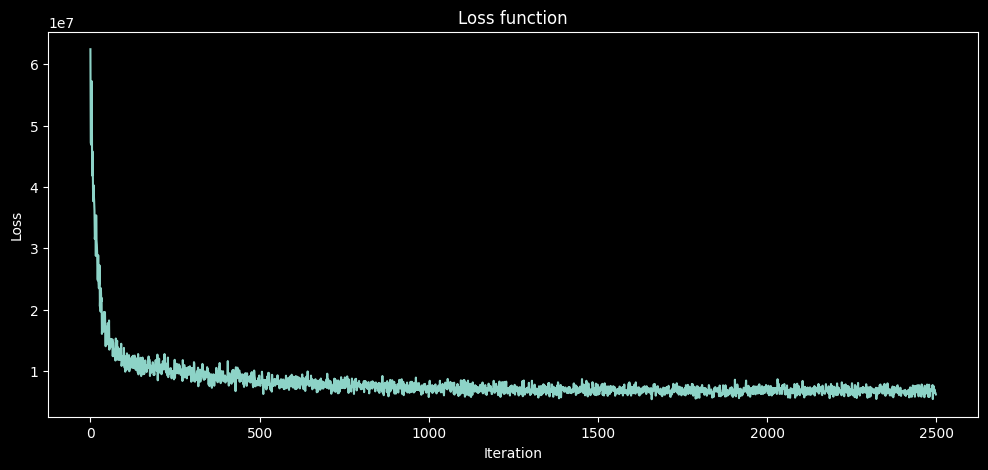

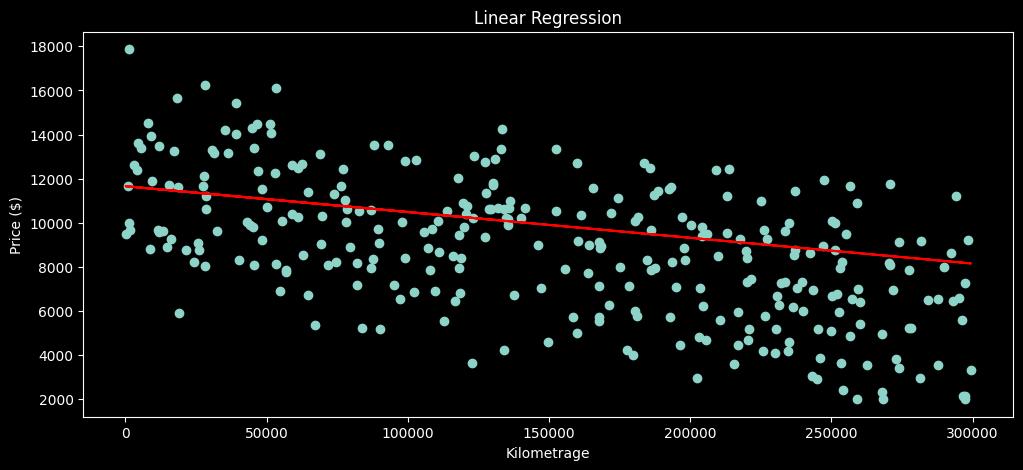

In [46]:

from matplotlib.axes import Axes


loss_fig, loss_ax = plt.subplots()
loss_fig.set_size_inches(12, 5)
loss_ax : Axes = loss_ax
loss_ax.plot(loss_history, label = "Loss")
loss_ax.set_xlabel("Iteration")
loss_ax.set_ylabel("Loss")
loss_ax.set_title("Loss function")



# Plot the data along with the line
data_plot, data_ax = plt.subplots()
data_plot.set_size_inches(12, 5)
data_ax : Axes = data_ax
sample = originalDf.sample(300)
data_ax.scatter(sample['Kilometrage'], sample['Price'])
data_ax.plot(sample['Kilometrage'], denormalized_b + denormalized_w1 * sample['Kilometrage'], color = 'red')
data_ax.set_xlabel("Kilometrage")
data_ax.set_ylabel("Price ($)")
data_ax.set_title("Linear Regression")

# Normal Equation
- Normal equation is another method to calculate the linear regression weights and balance to minimize the loss.
- Contrary to gradient descent, it is not an iterative method. Meaning that it finds the coeffcients directly.
- It uses the following formula
$$\theta = (X^{T}X)^{-1}X^Ty$$
- Where :
    - $\theta$ is the vector of the optimal value of the coefficients.
    - $X$ is a vector the input *features* values for each example.
    - $y$ is the vector of output values for each instance

In [47]:
def normal_equation(dataset : DataFrame):
    kilos = dataset["Kilometrage"]
    X =  np.stack([np.ones(kilos.size), kilos.values], axis = 1)
    Y = dataset["Price"].values
    return  np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)

ne_b,ne_w = normal_equation(df)
print("Normalized Bias: ", ne_b)
print("Normalized Weight: ", ne_w)
denormalized_ne_b = ne_b * (max_price - min_price) + min_price
denormalized_ne_w = ne_w * (max_price - min_price) / (max_kilometrage - min_kilometrage)
print("Denormalized Bias: ", denormalized_ne_b)
print("Denormalized Weight: ", denormalized_ne_w)
print("Loss: ", loss_func(df, ne_b, ne_w))

Normalized Bias:  0.6023405106995627
Normalized Weight:  -0.36569946110271323
Denormalized Bias:  11818.752664913573
Denormalized Weight:  -0.01235044023827529
Loss:  6743793.6042062435


## Remarks
- This method is a lot faster than gradient descent. Since the dataset's size is pretty small.
- It produced roughly the same bias, weight and loss.

Bias:  11819.249566350893
Weight:  -0.019876057493065917
Loss : 6743793.357295186


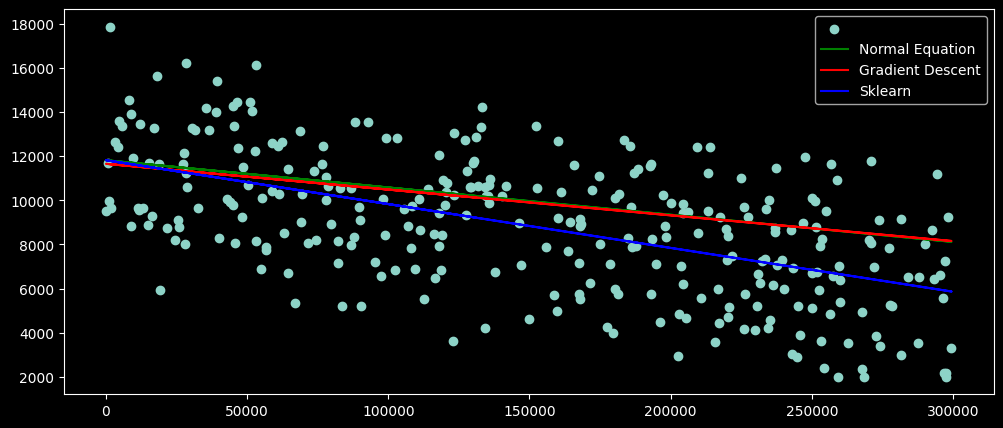

In [49]:
final_data_plot, final_data_ax = plt.subplots()
final_data_plot.set_size_inches(12, 5)
final_data_ax : Axes = final_data_ax
final_data_ax.scatter(sample['Kilometrage'], sample['Price'])


final_data_ax.plot()
final_data_ax.plot(sample['Kilometrage'], denormalized_ne_b + denormalized_ne_w * sample['Kilometrage'], color = 'green')
final_data_ax.plot(sample['Kilometrage'], denormalized_b + denormalized_w1 * sample['Kilometrage'], color = 'red')

# Compare with sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = originalDf["Kilometrage"].values.reshape(-1,1)
Y = originalDf["Price"].values
model = LinearRegression()
model.fit(X,Y)
print("Bias: ", model.intercept_)
print("Weight: ", model.coef_[0])
print("Loss :", mean_squared_error(Y, model.predict(X)))
# plot
final_data_ax.plot(sample['Kilometrage'], model.intercept_ + model.coef_[0] * sample['Kilometrage'], color = 'blue')
final_data_ax.legend(["","Normal Equation", "Gradient Descent", "Sklearn"])

# Final Remarks
- All of gradient descent, normal equation, and sklearn have similar loss at around 6.75 million.
- They also have similar biases.
- However, gradient descent and normal equation have a weight of around $-0.012$ while sklearn linear regression has a weight of around $-0.019$